# Deep Determenistic Uncertainty

В этом ноутбуки представлены результаты реализации метода [Deep Determenisic Uncertainty](https://arxiv.org/pdf/2102.11582.pdf) на датасете [отзывов о различных приложениях](https://huggingface.co/datasets/app_reviews) с таргетом 1, если отзыв имеет звезду 5, и 0 иначе.

Идея заключается в применение GDA (Gaussian Discriminant Analysis) к выходу сверточного слоя для оценки вероятности некоторого наблюдения. Главное предположение - чем меньше эта вероятность, тем меньше качество модели.

In [72]:
#!g2.mig
%load_ext autoreload
%autoreload 2

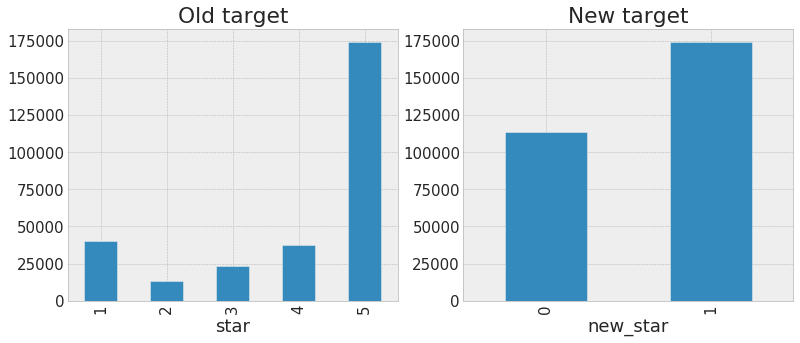

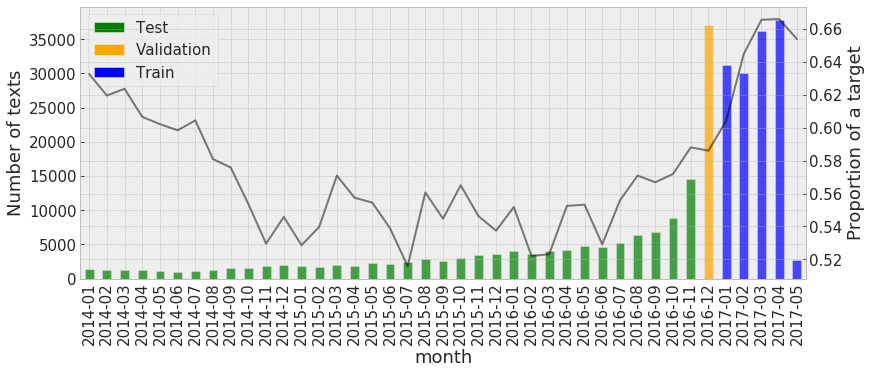

In [396]:
#!g2.mig
from datasets import load_dataset
from scripts.preprocessing import process, plot_data
from IPython.display import clear_output
import torch
from torch import nn
from torch.optim import Adam, SGD
from scripts.train import train 
from scripts.gda import GDA
from torch.utils.data import DataLoader
from scripts.dataset import TextDataset
from tqdm.notebook import tqdm
from scripts.test import test
import seaborn as sns
from scripts.test import test
import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd


def accuracy_rejection(probs, true_labels, predicted_labels, N = 115163, step = 1000):
    accuracy_score = lambda x,y: (x==y).mean()
    idx = np.argsort(probs)[::-1]
    r_rate = [0]
    r_accuracy = [accuracy_score(true_labels, predicted_labels)]
    for i in range(step, N, step):
        idx = idx[:(N - i)]
        r_rate.append(i / N)
        r_accuracy.append(accuracy_score(true_labels[idx], predicted_labels[idx]))
    return r_rate, r_accuracy


dataset = load_dataset("app_reviews")['train']
processed_dataset = process(dataset)
test_set = TextDataset(processed_dataset, 'test')
test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

clear_output()


models = ['Perfect','LogGDA', 'LogGMA_1', 'LogGMA_2', 'LogGMA_3','LogGMA_4', 'LogGMA_5', 'LogEnsemble']
sets = [gru,lstm,rnn]
for d in sets:
    mask = d['target'] != d['prediction']
    d.loc[mask, 'Perfect'] = np.arange(0, mask.sum())
    d.loc[~mask, 'Perfect'] = np.arange(mask.sum(), mask.sum() + (~mask).sum())
    
plot_data(dataset)

# RNN

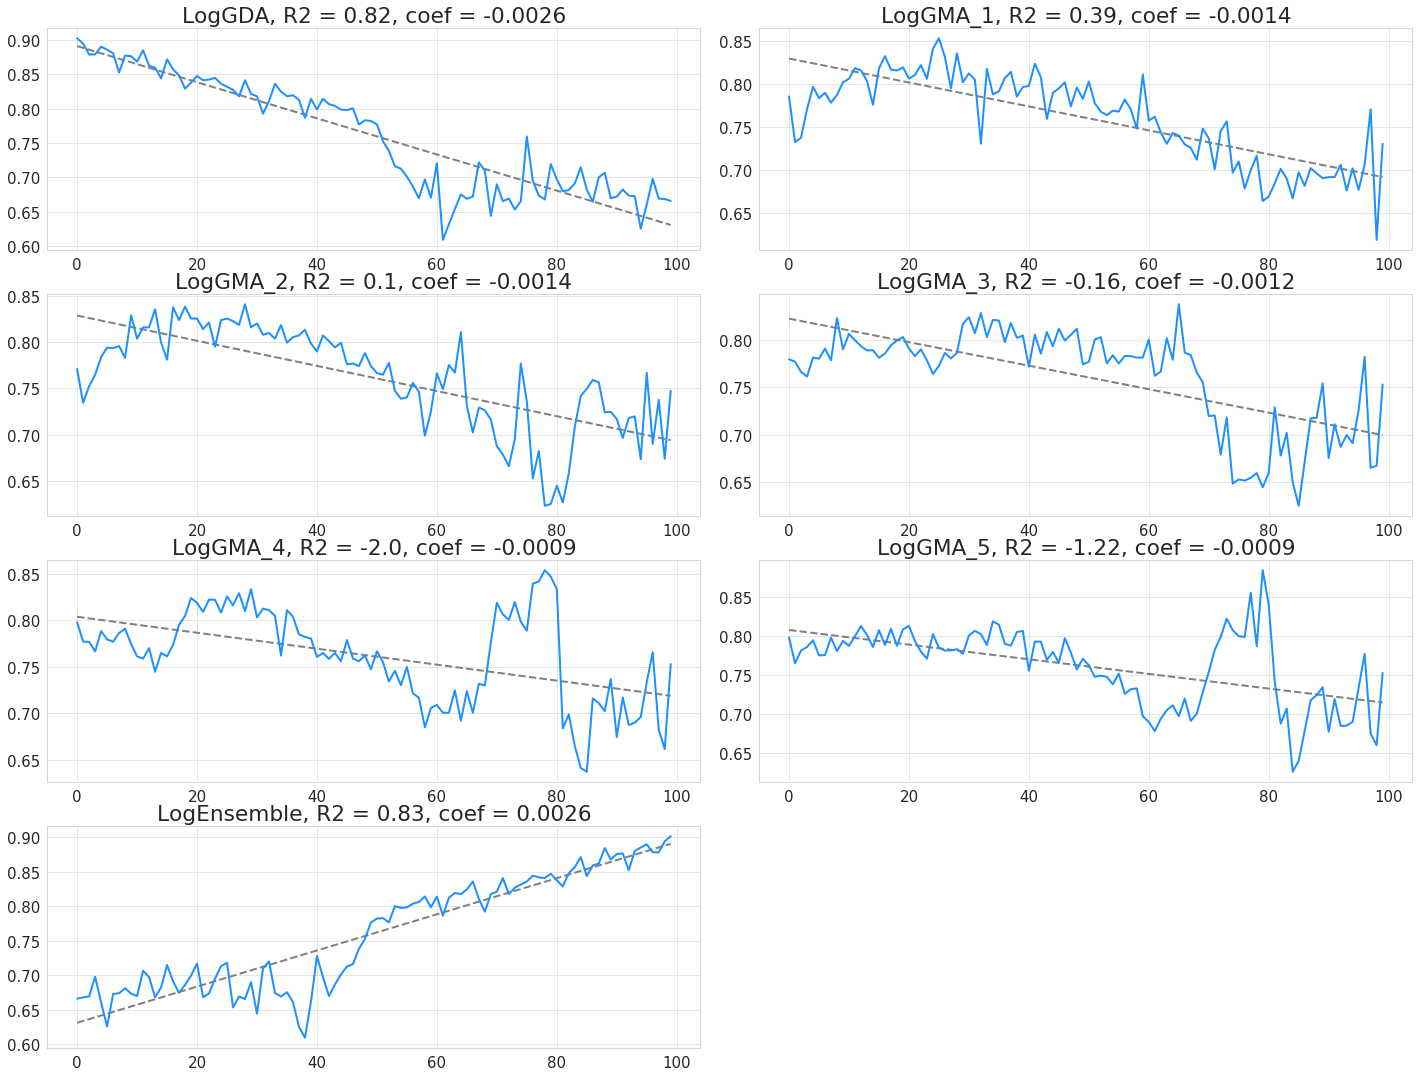

In [228]:
#!g2.mig
MODEL_NAME = 'rnn'

gda = GDA(MODEL_NAME)
gda.fit(processed_dataset)
rnn = test(gda.model.to(device), gda,test_loader)

clear_output()
show(rnn)

Text(0.5, 1.08, 'RNN Аггрегация по месяцам')

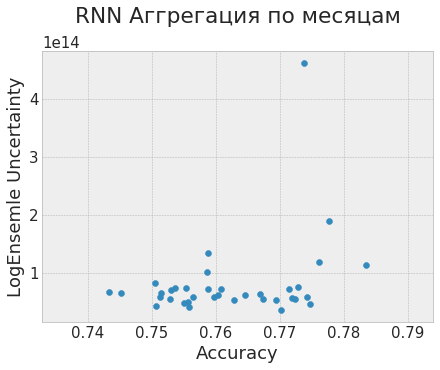

In [496]:
#!g2.mig
import matplotlib.cm as cm
rnn['loss'] = rnn['prediction'] == rnn['target']
rnn['month'] = rnn['date'].apply(lambda x: x[:-3])
pivot = rnn.pivot_table(index=['month'],
                values=['loss', 'LogEnsemble'],
                aggfunc=[np.mean])

plt.figure(figsize = (7,5))
plt.scatter(pivot[('mean','loss')],pivot[('mean', 'LogEnsemble')])
plt.ylabel('LogEnsemle Uncertainty')
plt.xlabel('Accuracy')
plt.title('RNN Аггрегация по месяцам', y = 1.08)


Text(0.5, 1.0, 'RNN Rejection curve')

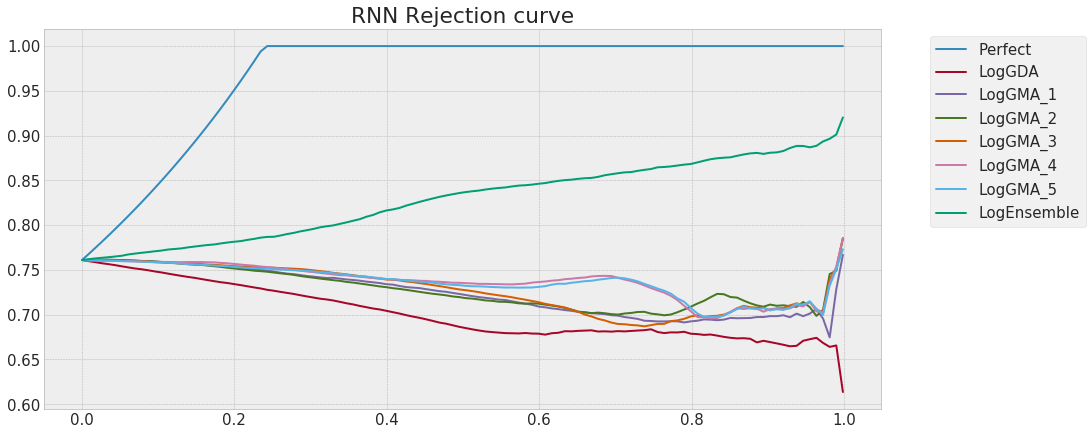

In [498]:
#!g2.mig
plt.figure(figsize = (15,7))
for model in models:
    grid, accuracy = accuracy_rejection(
        rnn[model],
        rnn['target'],
        rnn['prediction']
    )
    plt.plot(grid, accuracy, label = model)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('RNN Rejection curve')

### LSTM


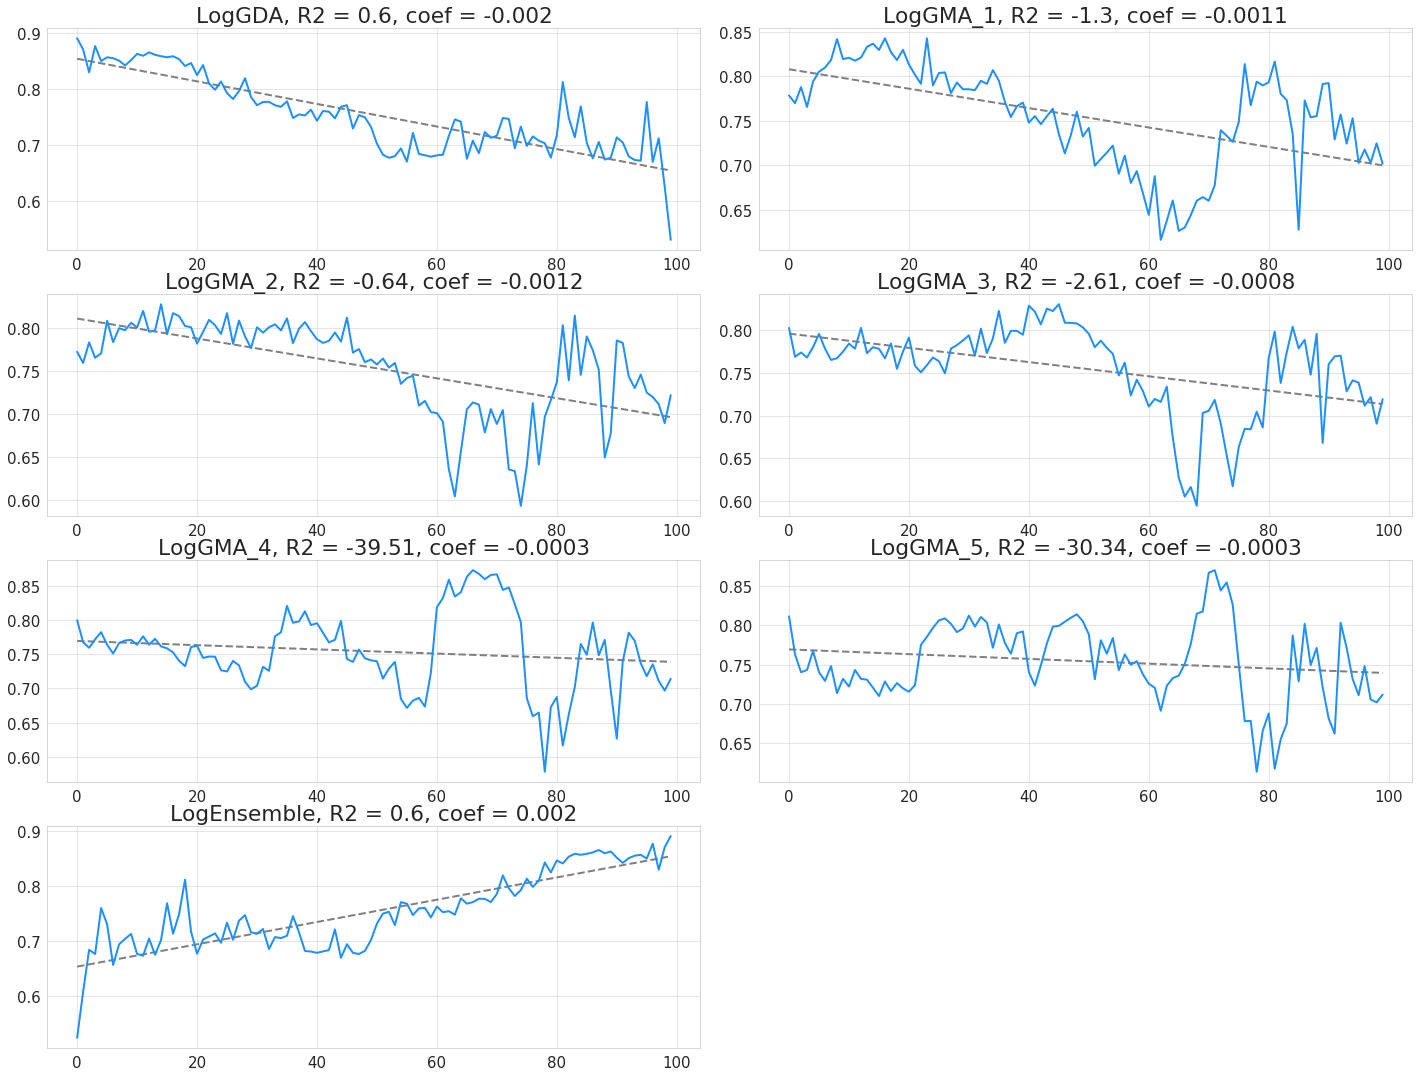

In [227]:
#!g2.mig
MODEL_NAME = 'lstm'

gda = GDA(MODEL_NAME)
gda.fit(processed_dataset)
lstm = test(gda.model.to(device), gda,test_loader)

clear_output()
show(lstm)

Text(0.5, 1.08, 'LSTM Аггрегация по месяцам')

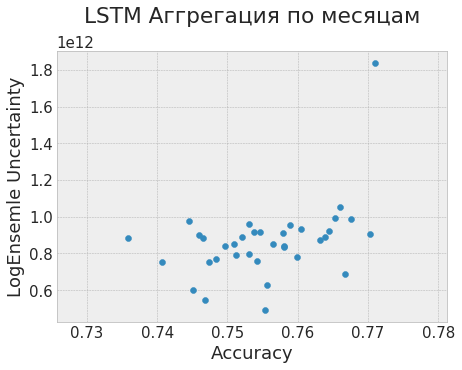

In [495]:
#!g2.mig
lstm['loss'] = lstm['prediction'] == lstm['target']
lstm['month'] = lstm['date'].apply(lambda x: x[:-3])
pivot = lstm.pivot_table(index=['month'],
                values=['loss', 'LogEnsemble'],
                aggfunc=[np.mean])

plt.figure(figsize = (7,5))
plt.scatter(pivot[('mean','loss')],pivot[('mean', 'LogEnsemble')])
plt.ylabel('LogEnsemle Uncertainty')
plt.xlabel('Accuracy')
plt.title('LSTM Аггрегация по месяцам', y = 1.08)

Text(0.5, 1.0, 'LSTM Rejection curve')

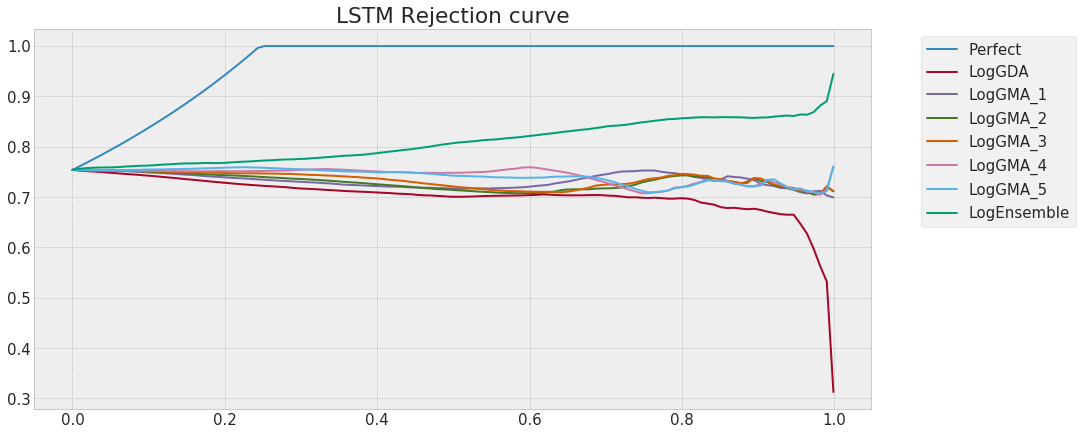

In [499]:
#!g2.mig
plt.figure(figsize = (15,7))
for model in models:
    grid, accuracy = accuracy_rejection(
        lstm[model],
        lstm['target'],
        lstm['prediction'])
    plt.plot(grid, accuracy, label = model)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('LSTM Rejection curve')

### GRU


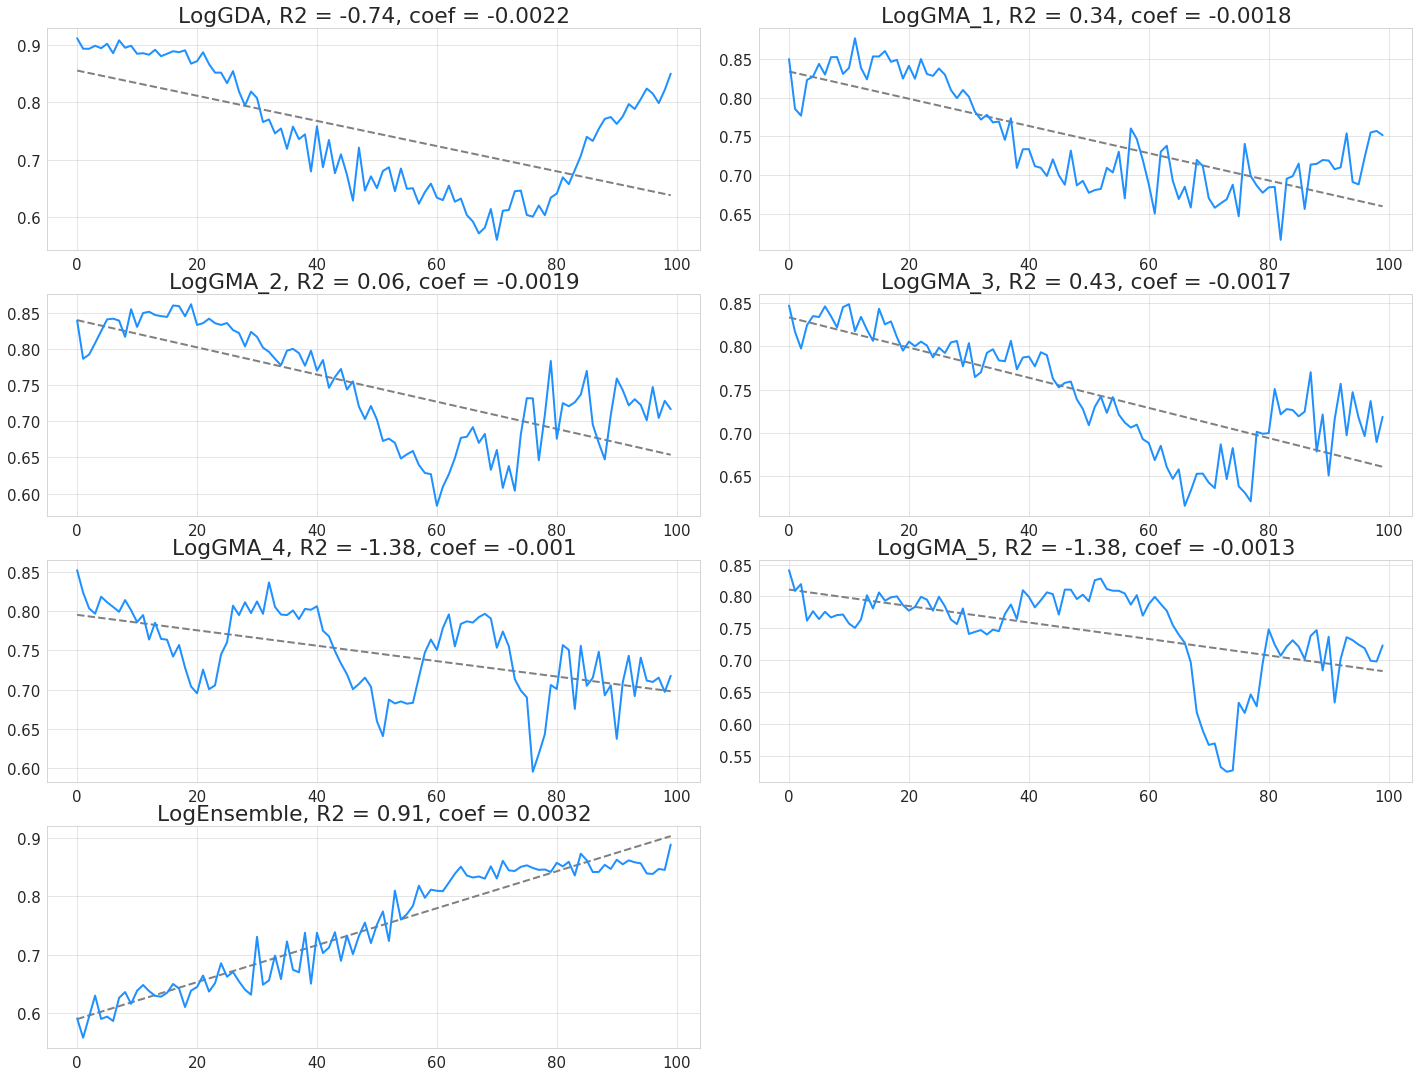

In [229]:
#!g2.mig
MODEL_NAME = 'gru'


gda = GDA(MODEL_NAME)
gda.fit(processed_dataset)
gru = test(gda.model.to(device), gda,test_loader)

clear_output()
show(gru)

Text(0.5, 1.08, 'LSTM Аггрегация по месяцам')

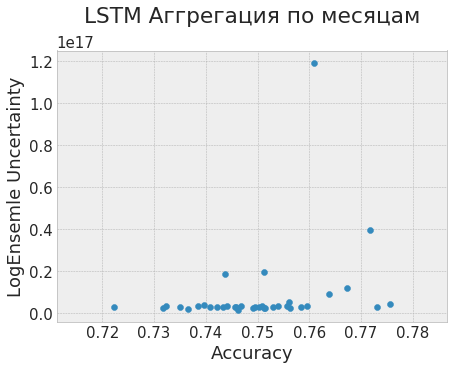

In [500]:
#!g2.mig
gru['loss'] = gru['prediction'] == gru['target']
gru['month'] = gru['date'].apply(lambda x: x[:-3])
pivot = gru.pivot_table(index=['month'],
                values=['loss', 'LogEnsemble'],
                aggfunc=[np.mean])

plt.figure(figsize = (7,5))
plt.scatter(pivot[('mean','loss')],pivot[('mean', 'LogEnsemble')])
plt.ylabel('LogEnsemle Uncertainty')
plt.xlabel('Accuracy')
plt.title('GRU Аггрегация по месяцам', y = 1.08)

Text(0.5, 1.0, 'GRU Rejection curve')

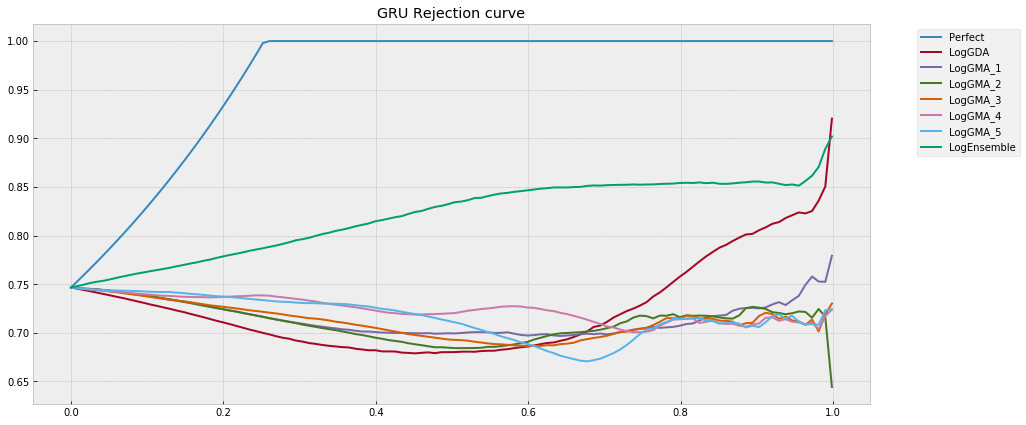

In [391]:
#!g2.mig
import matplotlib.pyplot as plt
plt.figure(figsize = (15,7))
for model in models:
    grid, accuracy = accuracy_rejection(
        gru[model],
        gru['target'],
        gru['prediction']
    )
    plt.plot(grid, accuracy, label = model)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('GRU Rejection curve')